In [1]:
using JuMP
using CSV
using LinearAlgebra
using DataFrames
using BARON
using Plots

In [28]:
A_db = CSV.File("./data/A_ren.csv",header=1,delim=",") |> DataFrame
B_db = CSV.File("./data/B_ren.csv",header=1,delim=",") |> DataFrame

A_mat=Matrix(A_db[:,2:size(A_db,2)])
B_mat=Matrix(B_db[:,2:size(B_db,2)])

f_val=sum(eachcol(A_mat))

nodes_val=names(A_db)[2:size(A_db,2)]
product_val=A_db[!,1]
intv_val=B_db[!,1]

10-element Vector{String31}:
 "Coal"
 "Natural Gas"
 "Waste"
 "Environment"
 "Oil"
 "Limestone "
 "Coal Energy"
 "NG Energy"
 "Environment Energy"
 "dummy electricity"

In [3]:
B_mat

10×36 Matrix{Float64}:
 -55.6882  -25.4601      0.0     …  0.0        0.0         0.0
 -52.8947  -24.0426    -62.8951     0.0        0.0         0.0
  20.7175   11.981      15.6427     0.0        0.0         0.0
  31.7886   13.2328      0.0        0.0        0.0         0.0
   0.0      -6.29662  -241.801      0.0        0.0         0.0
   0.0       0.0         0.0     …  0.0        0.0         0.0
 -59.4291  -18.6662    -59.11       0.0        0.0         0.0
 -31.7968   -9.98711   -31.62       0.0        0.0         0.0
  91.2258   28.6533     90.73       0.0117273  0.00572727  0.00218182
   0.0       0.0         0.0        1.0        1.0         1.0

In [4]:
function opt_decarb_base()
    dcrb =  Model(BARON.Optimizer)
    @variable(dcrb, 1 ≥ s[j=1:size(A_mat,2)] ≥ 0)
    @variable(dcrb,f[i=1:size(A_mat,1)] ≥ 0 )
    @variable(dcrb,g[k=1:size(B_mat,1)])
    @constraint(dcrb,[i=1:size(A_mat,1)],f[i] ≥ f_val[i])
    @constraint(dcrb,[i=1:size(A_mat,1)], f[i]==sum(A_mat[i,j]*s[j] for j in 1:size(A_mat,2)))
    @constraint(dcrb,[k=1:size(B_mat,1)],g[k]==sum(B_mat[k,j]*s[j] for j in 1:size(B_mat,2)))
    @variable(dcrb,obj)
    @constraint(dcrb,obj==sum(g[k] for k in 3:4)+g[9])
    @objective(dcrb,Min,obj)
    optimize!(dcrb)
    return JuMP.value.(s),JuMP.value.(f),JuMP.value.(obj)
end
    

opt_decarb_base (generic function with 1 method)

In [5]:
function opt_decarb_em()
    dcrb =  Model(BARON.Optimizer)
    @variable(dcrb,s[j=1:size(A_mat,2)] ≥ 0)
    @variable(dcrb,f[i=1:size(A_mat,1)] ≥ 0 )
    @variable(dcrb,g[k=1:size(B_mat,1)])
    @constraint(dcrb,[i=1:size(A_mat,1)],f[i] ≥ f_val[i])
    @constraint(dcrb,[i=1:size(A_mat,1)], f[i]==sum(A_mat[i,j]*s[j] for j in 1:size(A_mat,2)))
    @constraint(dcrb,[k=1:size(B_mat,1)],g[k]==sum(B_mat[k,j]*s[j] for j in 1:size(B_mat,2)))
    @variable(dcrb,obj)
    @constraint(dcrb,obj==sum(g[k] for k in 3:4)+g[9])
    @objective(dcrb,Min,obj)
    optimize!(dcrb)
    return JuMP.value.(s),JuMP.value.(f),JuMP.value.(obj),JuMP.value.(g)
end
    

opt_decarb_em (generic function with 1 method)

In [6]:
function opt_decarb_ruse()
    dcrb =  Model(BARON.Optimizer)
    @variable(dcrb,s[j=1:size(A_mat,2)] ≥ 0)
    @variable(dcrb,f[i=1:size(A_mat,1)] ≥ 0 )
    @variable(dcrb,g[k=1:size(B_mat,1)])
    @constraint(dcrb,[i=1:size(A_mat,1)],f[i] ≥ f_val[i])
    @constraint(dcrb,[i=1:size(A_mat,1)], f[i]==sum(A_mat[i,j]*s[j] for j in 1:size(A_mat,2)))
    @constraint(dcrb,[k=1:size(B_mat,1)],g[k]==sum(B_mat[k,j]*s[j] for j in 1:size(B_mat,2)))
    @variable(dcrb,obj)
    @constraint(dcrb,obj==-1*(sum(g[k] for k in 1:2)+sum(g[5:8])))
    @objective(dcrb,Min,obj)
    optimize!(dcrb)
    return JuMP.value.(s),JuMP.value.(f),JuMP.value.(obj),JuMP.value.(g)
end

opt_decarb_ruse (generic function with 1 method)

In [7]:
function opt_decarb_eps(lb,ub,ep)
    dcrb =  Model(BARON.Optimizer)
    set_optimizer_attribute(dcrb,"PrLevel",0)
    @variable(dcrb,s[j=1:size(A_mat,2)] ≥ 0)
    @variable(dcrb,f[i=1:size(A_mat,1)] ≥ 0 )
    @variable(dcrb,g[k=1:size(B_mat,1)])
    @constraint(dcrb,[i=1:size(A_mat,1)],f[i] ≥ f_val[i])
    @constraint(dcrb,[i=1:size(A_mat,1)], f[i]==sum(A_mat[i,j]*s[j] for j in 1:size(A_mat,2)))
    @constraint(dcrb,[k=1:size(B_mat,1)],g[k]==sum(B_mat[k,j]*s[j] for j in 1:size(B_mat,2)))
    @variable(dcrb,obj)
    @constraint(dcrb,-1*(sum(g[k] for k in 1:2)+sum(g[5:8])) ≤ lb+(ub-lb)*ep)
    @constraint(dcrb,obj==sum(g[k] for k in 3:4)+g[9])
    @objective(dcrb,Min,obj)
    optimize!(dcrb)
    return JuMP.value.(s),JuMP.value.(f),JuMP.value.(obj),JuMP.value.(g)
end

opt_decarb_eps (generic function with 1 method)

In [25]:
s,f,obj_em,g_em=opt_decarb_em()

 BARON version 21.1.13. Built: LNX-64 Wed Jan 13 16:09:31 EST 2021

 BARON is a product of The Optimization Firm.
 For information on BARON, see https://minlp.com/about-baron
 Licensee: Bhavik R. Bakshi at The Ohio State University, bakshi.2@osu.edu.

 If you use this software, please cite publications from
 https://minlp.com/baron-publications, such as: 

 Khajavirad, A. and N. V. Sahinidis,
 A hybrid LP/NLP paradigm for global optimization relaxations,
 Mathematical Programming Computation, 10, 383-421, 2018.
 This BARON run may utilize the following subsolver(s)
 For LP/MIP/QP: CLP/CBC                                         
 For NLP: IPOPT, FILTERSD, FILTERSQP
 Solving bounding LP
 Preprocessing found feasible solution with value  601.281432103     
 Problem solved during preprocessing
 Lower bound is  601.281432103     

 Calculating duals

                         *** Normal completion ***            

 Wall clock time:                     0.01
 Total CPU time used:             

([0.8633202767506457, 0.0, 1.0090556646688351, 0.9362144182838708, 1.0695784630053524, 1.958089321545877, 0.0, 1.9580893215458768, 1.0, 1.0000000000000002  …  1.0, 104.07496354714023, 104.07496354714021, 0.0, 108.5553886447529, 0.0, 0.0, 0.0, 0.0, 0.0], [26.640745321, 40.254667052, 0.7541263149999972, 42.891233347000004, 10.572503058999997, 13.331253301092978, 0.0, 12.023238060098125, 0.0, 43.6  …  9.335132529999996, 41.93128333, 6.951724138, 19.965538247645142, 7.2, 8.346, 1.923287671, 209.1198411, 0.0, 9.771998435], 601.2814321026955, [-48.07673992174012, -115.14135976599988, 65.06187988608677, 28.32594309633176, -577.0546185108866, 0.0, -335.0897306312267, -172.8038784760502, 507.89360912027695, -1278.5629215624108])

In [27]:
res_f=DataFrame(pdt=product_val, final_demand=f)
res_s=DataFrame(node=nodes_val, scaling_factor=s)

,node,scaling_factor
,String,Float64
1,Syngas Production,0.86332
2,Methanol Manufacture,0.0
3,Steam Cracker,1.00906
4,Hydrodealkylation (THD),0.936214
5,Disproportionation (TDP),1.06958
6,Metathesis,1.95809
7,Dehydrogenation,0.0
8,Refinery,1.95809
9,Urea Synthesis,1.0


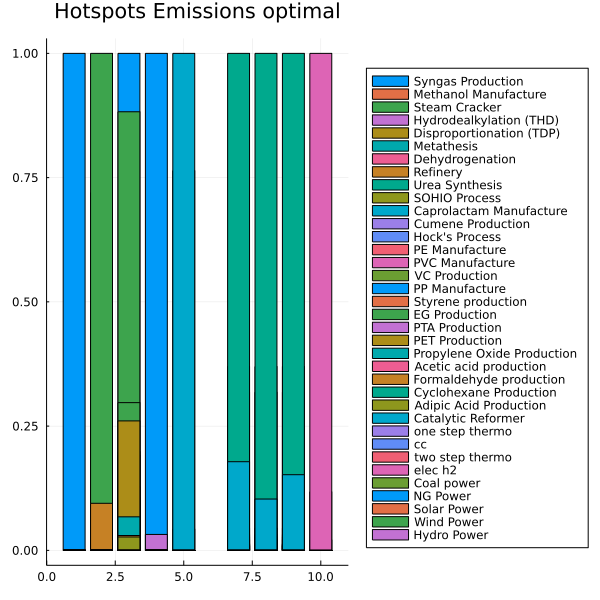

In [33]:
leg=reshape(nodes_val, 1,length(nodes_val))
htspts=abs.(B_mat.*s')
htspts=htspts./ maximum.(eachrow(htspts))
#delete!(htspts, 6)
bar(htspts,label=leg,legend=:outerbottomright,title="Hotspots Emissions optimal",size = (600, 600))

In [34]:
s,f,obj_ru,g_ru=opt_decarb_ruse()

 BARON version 21.1.13. Built: LNX-64 Wed Jan 13 16:09:31 EST 2021

 BARON is a product of The Optimization Firm.
 For information on BARON, see https://minlp.com/about-baron
 Licensee: Bhavik R. Bakshi at The Ohio State University, bakshi.2@osu.edu.

 If you use this software, please cite publications from
 https://minlp.com/baron-publications, such as: 

 Khajavirad, A. and N. V. Sahinidis,
 A hybrid LP/NLP paradigm for global optimization relaxations,
 Mathematical Programming Computation, 10, 383-421, 2018.
 This BARON run may utilize the following subsolver(s)
 For LP/MIP/QP: CLP/CBC                                         
 For NLP: IPOPT, FILTERSD, FILTERSQP
 Solving bounding LP
 Preprocessing found feasible solution with value  1236.57266061     
 Problem solved during preprocessing
 Lower bound is  1236.57266061     

 Calculating duals

                         *** Normal completion ***            

 Wall clock time:                     0.01
 Total CPU time used:             

([0.8633202767506459, 0.0, 1.0, 0.9999999999999964, 1.0000000000000024, 0.9999999999999996, 0.9999999999999993, 0.9999999999999996, 1.0, 1.0000000000000002  …  1.0, 104.0749635471402, 104.07496354714017, 0.0, 108.55538864475282, 0.0, 0.0, 0.0, 0.0, 0.0], [26.640745321, 40.254667052, 0.7541263149999972, 42.891233347000004, 10.572503058999997, 12.947543132999996, 0.0, 0.0, 0.0, 43.6  …  9.335132529999996, 41.93128333, 6.951724138, 19.78635961, 7.2, 8.346, 1.923287671, 209.1198411, 0.0, 9.771998435], 1236.5726606139244, [-48.07673992174013, -111.63032885144796, 65.1966782164045, 28.38604874062156, -568.1744265322437, 0.0, -335.6092627729593, -173.08190253553337, 508.69116532149263, -1278.56292156241])

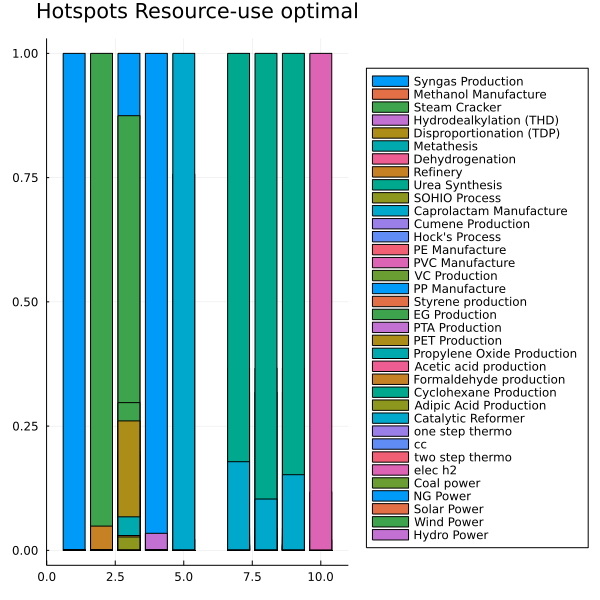

In [35]:
leg=reshape(nodes_val, 1,length(nodes_val))
htspts=abs.(B_mat.*s')
htspts=htspts./ maximum.(eachrow(htspts))
#delete!(htspts, 6)
bar(htspts,label=leg,legend=:outerbottomright,title="Hotspots Resource-use optimal",size = (600, 600))

In [36]:
res_f=DataFrame(pdt=product_val, final_demand=f)
res_s=DataFrame(node=nodes_val, scaling_factor=s)

,node,scaling_factor
,String,Float64
1,Syngas Production,0.86332
2,Methanol Manufacture,0.0
3,Steam Cracker,1.0
4,Hydrodealkylation (THD),1.0
5,Disproportionation (TDP),1.0
6,Metathesis,1.0
7,Dehydrogenation,1.0
8,Refinery,1.0
9,Urea Synthesis,1.0


In [37]:
ub_em=(sum(g_ru[3:4])+sum(g_ru[9:9]))
ub=-1*(sum(g_em[1:2])+sum(g_em[5:8]))
lb=obj_ru

e_vec=[0.1 0.2 0.3 0.4 0.5 0.6 0.7 0.8 0.9]
eps_res=DataFrame(Emissions=[obj_em,ub_em], Resource_Use=[ub,lb])
for i in 1:size(e_vec,2)
    s,f,obj_eps,g_eps=opt_decarb_eps(lb,ub,e_vec[i])
    temp_ru=-1*(sum(g_eps[1:2])+sum(g_eps[5:8]))
    #eps_res=eps_res.append({'Emissions':obj_eps,'Resource_Use':temp_ru})
    push!(eps_res,[obj_eps, temp_ru])
end
eps_res

 Unable to find/load CPLEX library libcplex.so: cannot open shared object file: No such file or directory
 Unable to find/load CPLEX library libcplex2010.so: cannot open shared object file: No such file or directory
 Unable to find/load CPLEX library libcplex.so: cannot open shared object file: No such file or directory
 Unable to find/load CPLEX library libcplex2010.so: cannot open shared object file: No such file or directory
 Unable to find/load CPLEX library libcplex.so: cannot open shared object file: No such file or directory
 Unable to find/load CPLEX library libcplex2010.so: cannot open shared object file: No such file or directory
 Unable to find/load CPLEX library libcplex.so: cannot open shared object file: No such file or directory
 Unable to find/load CPLEX library libcplex2010.so: cannot open shared object file: No such file or directory
 Unable to find/load CPLEX library libcplex.so: cannot open shared object file: No such file or directory
 Unable to find/load CPLEX lib

,Emissions,Resource_Use
,Float64,Float64
1,601.281,1248.17
2,602.274,1236.57
3,602.175,1237.73
4,602.075,1238.89
5,601.976,1240.05
6,601.877,1241.21
7,601.778,1242.37
8,601.678,1243.53
9,601.579,1244.69


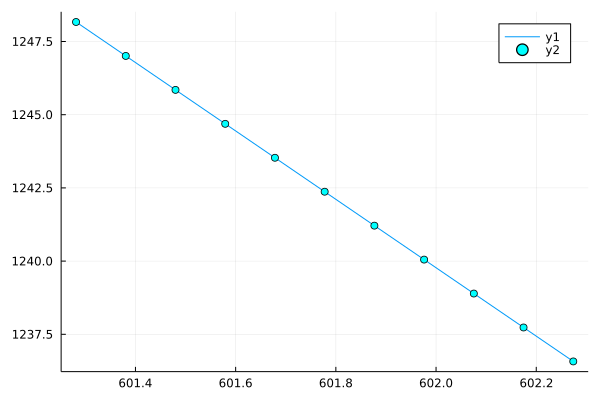

In [38]:
sort!(eps_res,:Emissions)
plot(eps_res[!,:Emissions],eps_res[!,:Resource_Use])
plot!(eps_res[!,:Emissions],eps_res[!,:Resource_Use], seriestype = :scatter, color="cyan")

In [39]:
eps_res

,Emissions,Resource_Use
,Float64,Float64
1,601.281,1248.17
2,601.381,1247.01
3,601.48,1245.85
4,601.579,1244.69
5,601.678,1243.53
6,601.778,1242.37
7,601.877,1241.21
8,601.976,1240.05
9,602.075,1238.89


## Sensitivity optimization

In [40]:
function sens_opt_decarb_em()
    dcrb =  Model(BARON.Optimizer)
    @variable(dcrb,s[j=1:size(A_mat,2)] ≥ 0)
    @variable(dcrb,f[i=1:size(A_mat,1)] ≥ 0 )
    @variable(dcrb,g[k=1:size(B_mat,1)])
    
    
    @variable(dcrb,y1[i=1:size(A_mat,1),j=1:size(A_mat,2)],Bin)
    @variable(dcrb,y2[i=1:size(A_mat,1),j=1:size(A_mat,2)],Bin)
    @variable(dcrb,y[i=1:size(A_mat,1),j=1:size(A_mat,2)],Bin)
    @constraint(dcrb,[i=1:size(A_mat,1),j=1:size(A_mat,2)],y[i,j] == y1[i,j]+y2[i,j])
    @constraint(dcrb,sum(y[i,j] for i in 1:size(A_mat,1), j=1:size(A_mat,2)) ≤ 10) 
    
    @constraint(dcrb,[i=1:size(A_mat,1)],f[i] ≥ f_val[i])
    @constraint(dcrb,[i=1:size(A_mat,1)], f[i]==sum(A_mat[i,j]*(1+0.1*y1[i,j]-0.1*y2[i,j])*s[j] for j in 1:size(A_mat,2)))
    @constraint(dcrb,[k=1:size(B_mat,1)],g[k]==sum(B_mat[k,j]*s[j] for j in 1:size(B_mat,2)))
    @variable(dcrb,obj)
    @constraint(dcrb,obj==sum(g[k] for k in 3:4)+g[9])
    @objective(dcrb,Min,obj)
    optimize!(dcrb)
    return JuMP.value.(s),JuMP.value.(f),JuMP.value.(obj),JuMP.value.(g),JuMP.value.(y1),JuMP.value.(y2)
end
    

sens_opt_decarb_em (generic function with 1 method)

In [41]:
function sens_opt_decarb_ru()
    dcrb =  Model(BARON.Optimizer)
    @variable(dcrb,s[j=1:size(A_mat,2)] ≥ 0)
    @variable(dcrb,f[i=1:size(A_mat,1)] ≥ 0 )
    @variable(dcrb,g[k=1:size(B_mat,1)])
    
    
    @variable(dcrb,y1[i=1:size(A_mat,1),j=1:size(A_mat,2)],Bin)
    @variable(dcrb,y2[i=1:size(A_mat,1),j=1:size(A_mat,2)],Bin)
    @variable(dcrb,y[i=1:size(A_mat,1),j=1:size(A_mat,2)],Bin)
    @constraint(dcrb,[i=1:size(A_mat,1),j=1:size(A_mat,2)],y[i,j] == y1[i,j]+y2[i,j])
    @constraint(dcrb,sum(y[i,j] for i in 1:size(A_mat,1), j=1:size(A_mat,2)) ≤ 10) 
    
    @constraint(dcrb,[i=1:size(A_mat,1)],f[i] ≥ f_val[i])
    @constraint(dcrb,[i=1:size(A_mat,1)], f[i]==sum(A_mat[i,j]*(1+0.1*y1[i,j]-0.1*y2[i,j])*s[j] for j in 1:size(A_mat,2)))
    @constraint(dcrb,[k=1:size(B_mat,1)],g[k]==sum(B_mat[k,j]*s[j] for j in 1:size(B_mat,2)))
    @variable(dcrb,obj)
    @constraint(dcrb,obj==-1*(sum(g[k] for k in 1:2)+sum(g[5:8])))
    @objective(dcrb,Min,obj)
    optimize!(dcrb)
    return JuMP.value.(s),JuMP.value.(f),JuMP.value.(obj),JuMP.value.(g),JuMP.value.(y1),JuMP.value.(y2)
end
    

sens_opt_decarb_ru (generic function with 1 method)

In [42]:
function sens_opt_decarb_eps(lb,ub,ep)
    dcrb =  Model(BARON.Optimizer)
    set_optimizer_attribute(dcrb,"PrLevel",0)
    @variable(dcrb,s[j=1:size(A_mat,2)] ≥ 0)
    @variable(dcrb,f[i=1:size(A_mat,1)] ≥ 0 )
    @variable(dcrb,g[k=1:size(B_mat,1)])
    
    
    @variable(dcrb,y1[i=1:size(A_mat,1),j=1:size(A_mat,2)],Bin)
    @variable(dcrb,y2[i=1:size(A_mat,1),j=1:size(A_mat,2)],Bin)
    @variable(dcrb,y[i=1:size(A_mat,1),j=1:size(A_mat,2)],Bin)
    @constraint(dcrb,[i=1:size(A_mat,1),j=1:size(A_mat,2)],y[i,j] == y1[i,j]+y2[i,j])
    @constraint(dcrb,sum(y[i,j] for i in 1:size(A_mat,1), j=1:size(A_mat,2)) ≤ 10) 
    
    @constraint(dcrb,[i=1:size(A_mat,1)],f[i] ≥ f_val[i])
    @constraint(dcrb,[i=1:size(A_mat,1)], f[i]==sum(A_mat[i,j]*(1+0.1*y1[i,j]-0.1*y2[i,j])*s[j] for j in 1:size(A_mat,2)))
    @constraint(dcrb,[k=1:size(B_mat,1)],g[k]==sum(B_mat[k,j]*s[j] for j in 1:size(B_mat,2)))
    @variable(dcrb,obj)
    @constraint(dcrb,-1*(sum(g[k] for k in 1:2)+sum(g[5:8])) ≤ lb+(ub-lb)*ep)
    @constraint(dcrb,obj==sum(g[k] for k in 3:4)+g[9])
    @objective(dcrb,Min,obj)
    optimize!(dcrb)
    return JuMP.value.(s),JuMP.value.(f),JuMP.value.(obj),JuMP.value.(g),JuMP.value.(y1),JuMP.value.(y2)
end
    

sens_opt_decarb_eps (generic function with 1 method)

In [43]:
s,f,obj_em,g_em,y1,y2=sens_opt_decarb_em()

 BARON version 21.1.13. Built: LNX-64 Wed Jan 13 16:09:31 EST 2021

 BARON is a product of The Optimization Firm.
 For information on BARON, see https://minlp.com/about-baron
 Licensee: Bhavik R. Bakshi at The Ohio State University, bakshi.2@osu.edu.

 If you use this software, please cite publications from
 https://minlp.com/baron-publications, such as: 

 Kilinc, M. and N. V. Sahinidis, Exploiting integrality in the global
 optimization of mixed-integer nonlinear programming problems in BARON,
 Optimization Methods and Software, 33, 540-562, 2018.
 This BARON run may utilize the following subsolver(s)
 For LP/MIP/QP: CLP/CBC                                         
 For NLP: IPOPT, FILTERSD, FILTERSQP
 Doing local search
 Preprocessing found feasible solution with value  533.968082806     
 Solving bounding LP
 Starting multi-start local search
 Done with local search
  Iteration    Open nodes         Time (s)    Lower bound      Upper bound
*         1             1             3.64

([0.6532993689204766, 0.0, 0.9113257882135315, 1.7985470868671167, 0.2888400447741974, 3.0579222292342463, 0.0, 3.0579222292342463, 0.9090909090909091, 1.0  …  0.9279600691626648, 104.07496353487993, 104.0749635348799, 0.0, 119.45131537674415, 0.0, 0.0, 0.0, 0.0, 0.0], [26.640745321, 40.254667052, 0.754126314999997, 42.891233347000004, 10.572503058999997, 12.947543132999996, 0.0, 18.776532064596058, 0.0, 43.6  …  9.335132529999996, 41.93128333, 6.951724138, 19.8350017442056, 7.2, 8.346, 1.923287671, 213.46034843148564, 0.0, 9.771998435645928], 532.8222091016894, [-36.38105660026829, -101.26228601330081, 58.27101278233485, 22.46225563598593, -538.0949143674394, 0.0, -298.4314980757276, -153.65744259602081, 452.0889406833686, -1391.2638501037436], [0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0; … ; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0], [0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0; … ; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0])

In [44]:
print(" Positive perturbations \n\n")

for i in 1:size(findall(x->x==1, y1),1)
    print(nodes_val[findall(x->x==1, y1)[i][2]]*" ---- "*product_val[findall(x->x==1, y1)[i][1]]*"\n")
end   
print("\n Negative perturbations \n\n")
for i in 1:size(findall(x->x==1, y2),1)
    print(nodes_val[findall(x->x==1, y2)[i][2]]*" ---- "*product_val[findall(x->x==1, y2)[i][1]]*"\n")
end   

 Positive perturbations 

Syngas Production ---- Syngas
Steam Cracker ---- Ethylene 
Steam Cracker ---- Butadiene 
Urea Synthesis ---- Urea 
PET Production ---- Polyethylene Terephthalate (PET)
Catalytic Reformer ---- Toluene 
Catalytic Reformer ---- Gasoline Additives

 Negative perturbations 

Urea Synthesis ---- Syngas


In [45]:

per_em=""
for i in 1:size(findall(x->x==1, y1),1)
    pos_em=nodes_val[findall(x->x==1, y1)[i][2]]*" ---- "*product_val[findall(x->x==1, y1)[i][1]]*"\n"
    per_em=per_em*pos_em
end   
per_em=per_em*"\n\n"
for i in 1:size(findall(x->x==1, y2),1)
    neg_em=nodes_val[findall(x->x==1, y2)[i][2]]*" ---- "*product_val[findall(x->x==1, y2)[i][1]]*"\n"
    per_em=per_em*neg_em
end  
per_em=replace(per_em,"\n"=>" | ")
print("\n")

In [46]:
s,f,obj_ru,g_ru,y1,y2=sens_opt_decarb_ru()

 BARON version 21.1.13. Built: LNX-64 Wed Jan 13 16:09:31 EST 2021

 BARON is a product of The Optimization Firm.
 For information on BARON, see https://minlp.com/about-baron
 Licensee: Bhavik R. Bakshi at The Ohio State University, bakshi.2@osu.edu.

 If you use this software, please cite publications from
 https://minlp.com/baron-publications, such as: 

 Kilinc, M. and N. V. Sahinidis, Exploiting integrality in the global
 optimization of mixed-integer nonlinear programming problems in BARON,
 Optimization Methods and Software, 33, 540-562, 2018.
 This BARON run may utilize the following subsolver(s)
 For LP/MIP/QP: CLP/CBC                                         
 For NLP: IPOPT, FILTERSD, FILTERSQP
 Doing local search
 Preprocessing found feasible solution with value  1157.26871817     
 Solving bounding LP
 Starting multi-start local search
 Done with local search
  Iteration    Open nodes         Time (s)    Lower bound      Upper bound
*         1             1             3.52

([0.6532993689204774, 0.0, 0.9090909090909092, 1.9621480953877442, 0.04484684809463392, 0.9999999999999991, 0.9999999999999991, 0.9999999999999991, 0.9090909090909091, 1.0  …  0.9133757801376843, 104.07507418452983, 104.07507418452981, 0.0, 119.45645752503717, 0.037329327554165986, 0.015082050765667753, 0.0011312773024035271, 0.0003012530162717484, 0.0], [26.640745321, 40.254667052, 0.754126314999997, 42.891233347000004, 10.572503058999997, 12.947543132999996, 0.0, 0.0, 0.0, 43.6  …  9.335132529999996, 41.93128333, 6.951724138, 19.78635961, 7.2, 8.34603896711096, 1.923287671, 210.1054978076792, 0.0, 9.772964815334364], 1105.7689142889099, [-36.38105660026833, -94.80360238896006, 59.57239079711856, 22.6164181247339, -518.5255851684807, 0.0, -300.9560452931338, -155.1026248380668, 456.07058852103717, -1391.2633590608136], [0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0; … ; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0], [0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0; … ; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0])

In [47]:
print(" Positive perturbations \n\n")
per_ru=""
for i in 1:size(findall(x->x==1, y1),1)
    pos_ru=nodes_val[findall(x->x==1, y1)[i][2]]*" ---- "*product_val[findall(x->x==1, y1)[i][1]]*"\n"
    print(pos_ru)
    per_ru=per_ru*pos_ru
end   
print("\n\n Negative perturbations \n\n")
per_ru=per_ru*"\n\n"
for i in 1:size(findall(x->x==1, y2),1)
    neg_ru=nodes_val[findall(x->x==1, y2)[i][2]]*" ---- "*product_val[findall(x->x==1, y2)[i][1]]*"\n"
    print(neg_ru)
    per_ru=per_ru*neg_ru
end  
per_ru=replace(per_ru,"\n"=>" | ")
print("\n")

 Positive perturbations 

Syngas Production ---- Syngas
Steam Cracker ---- Ethylene 
Steam Cracker ---- Propylene 
Steam Cracker ---- Butadiene 
Urea Synthesis ---- Urea 
Catalytic Reformer ---- Toluene 
Catalytic Reformer ---- Xylene 
Catalytic Reformer ---- Gasoline Additives


 Negative perturbations 

Urea Synthesis ---- Syngas
PTA Production ---- Xylene 



In [48]:
function get_per_str(y1,y2)
    per_em=""
    for i in 1:size(findall(x->x==1, y1),1)
        pos_em=nodes_val[findall(x->x==1, y1)[i][2]]*" ---- "*product_val[findall(x->x==1, y1)[i][1]]*"\n"
        per_em=per_em*pos_em
    end   
    per_em=per_em*"\n\n"
    for i in 1:size(findall(x->x==1, y2),1)
        neg_em=nodes_val[findall(x->x==1, y2)[i][2]]*" ---- "*product_val[findall(x->x==1, y2)[i][1]]*"\n"
        per_em=per_em*neg_em
    end  
    per_em=replace(per_em,"\n"=>" | ")
    print("\n")
    return per_em
end


get_per_str (generic function with 1 method)

In [49]:
ub_em=(sum(g_ru[3:4])+sum(g_ru[9:9]))
ub=-1*(sum(g_em[1:2])+sum(g_em[5:8]))
lb=obj_ru

e_vec=[0.1 0.2 0.3 0.4 0.5 0.6 0.7 0.8 0.9]
eps_res_sens=DataFrame(Emissions=[obj_em,ub_em], Resource_Use=[ub,lb], Perturbations=[per_em,per_ru])
for i in 1:size(e_vec,2)
    s,f,obj_eps,g_eps,y1,y2=sens_opt_decarb_eps(lb,ub,e_vec[i])
    temp_ru=-1*(sum(g_eps[1:2])+sum(g_eps[5:8]))
    #eps_res=eps_res.append({'Emissions':obj_eps,'Resource_Use':temp_ru})
    push!(eps_res_sens,[obj_eps, temp_ru,get_per_str(y1,y2)])
end

 Unable to find/load CPLEX library libcplex.so: cannot open shared object file: No such file or directory
 Unable to find/load CPLEX library libcplex2010.so: cannot open shared object file: No such file or directory

 Unable to find/load CPLEX library libcplex.so: cannot open shared object file: No such file or directory
 Unable to find/load CPLEX library libcplex2010.so: cannot open shared object file: No such file or directory

 Unable to find/load CPLEX library libcplex.so: cannot open shared object file: No such file or directory
 Unable to find/load CPLEX library libcplex2010.so: cannot open shared object file: No such file or directory

 Unable to find/load CPLEX library libcplex.so: cannot open shared object file: No such file or directory
 Unable to find/load CPLEX library libcplex2010.so: cannot open shared object file: No such file or directory

 Unable to find/load CPLEX library libcplex.so: cannot open shared object file: No such file or directory
 Unable to find/load CPLEX

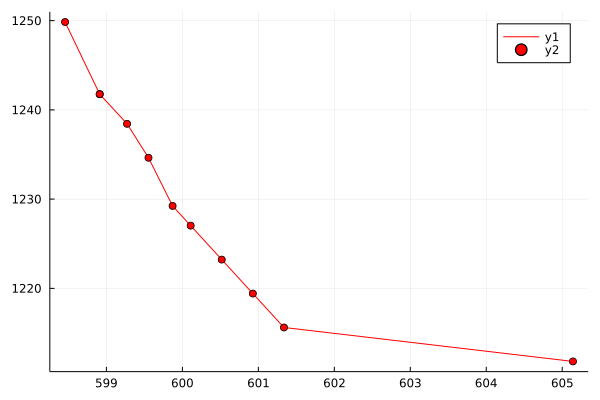

In [26]:
sort!(eps_res_sens,:Emissions)
plot(eps_res_sens[!,:Emissions],eps_res_sens[!,:Resource_Use],color="red")
plot!(eps_res_sens[!,:Emissions],eps_res_sens[!,:Resource_Use], seriestype = :scatter, color="red")

In [27]:
eps_res_sens

,Emissions,Resource_Use,Perturbations
,Float64,Float64,String
1,598.456,1249.85,Syngas Production ---- Syngas | Methanol Manufacture ---- Methanol | Steam Cracker ---- Ethylene | Steam Cracker ---- Butadiene | Urea Synthesis ---- Urea | EG Production ---- Ethylene glycol | PET Production ---- Polyethylene Terephthalate (PET) | | | Methanol Manufacture ---- Syngas | Urea Synthesis ---- Syngas | Formaldehyde production ---- Methanol |
2,598.912,1241.76,Syngas Production ---- Syngas | Methanol Manufacture ---- Methanol | Steam Cracker ---- Ethylene | Steam Cracker ---- Butadiene | Urea Synthesis ---- Urea | PP Manufacture ---- Polypropylene | PET Production ---- Polyethylene Terephthalate (PET) | | | Methanol Manufacture ---- Syngas | Urea Synthesis ---- Syngas |
3,598.912,1241.76,Syngas Production ---- Syngas | Steam Cracker ---- Ethylene | Steam Cracker ---- Butadiene | Urea Synthesis ---- Urea | PET Production ---- Polyethylene Terephthalate (PET) | | | Urea Synthesis ---- Syngas | Formaldehyde production ---- Methanol |
4,599.272,1238.44,Syngas Production ---- Syngas | Steam Cracker ---- Butadiene | Urea Synthesis ---- Urea | PP Manufacture ---- Polypropylene | PET Production ---- Polyethylene Terephthalate (PET) | | | Urea Synthesis ---- Syngas | Formaldehyde production ---- Methanol |
5,599.554,1234.64,Syngas Production ---- Syngas | Methanol Manufacture ---- Methanol | Steam Cracker ---- Ethylene | Steam Cracker ---- Propylene | Steam Cracker ---- Butadiene | Urea Synthesis ---- Urea | PET Production ---- Polyethylene Terephthalate (PET) | | | Methanol Manufacture ---- Syngas | Urea Synthesis ---- Syngas |
6,599.871,1229.24,Syngas Production ---- Syngas | Methanol Manufacture ---- Methanol | Steam Cracker ---- Ethylene | Steam Cracker ---- Butadiene | Urea Synthesis ---- Urea | PTA Production ---- Terephthalic Acid (PTA) | PET Production ---- Polyethylene Terephthalate (PET) | Catalytic Reformer ---- Toluene | Catalytic Reformer ---- Gasoline Additives | | | Urea Synthesis ---- Syngas |
7,600.109,1227.03,Syngas Production ---- Syngas | Methanol Manufacture ---- Methanol | Steam Cracker ---- Ethylene | Steam Cracker ---- Butadiene | Urea Synthesis ---- Urea | PTA Production ---- Terephthalic Acid (PTA) | PET Production ---- Polyethylene Terephthalate (PET) | Catalytic Reformer ---- Toluene | Catalytic Reformer ---- Gasoline Additives | | | Urea Synthesis ---- Syngas |
8,600.518,1223.22,Syngas Production ---- Syngas | Methanol Manufacture ---- Methanol | Steam Cracker ---- Ethylene | Steam Cracker ---- Butadiene | Urea Synthesis ---- Urea | PTA Production ---- Terephthalic Acid (PTA) | PET Production ---- Polyethylene Terephthalate (PET) | Catalytic Reformer ---- Toluene | Catalytic Reformer ---- Gasoline Additives | | | Urea Synthesis ---- Syngas |
9,600.928,1219.42,Syngas Production ---- Syngas | Methanol Manufacture ---- Methanol | Steam Cracker ---- Ethylene | Steam Cracker ---- Butadiene | Urea Synthesis ---- Urea | PTA Production ---- Terephthalic Acid (PTA) | PET Production ---- Polyethylene Terephthalate (PET) | Catalytic Reformer ---- Toluene | Catalytic Reformer ---- Gasoline Additives | | | Urea Synthesis ---- Syngas |


In [108]:
function sens_opt_decarb_em()
    dcrb =  Model(BARON.Optimizer)
    @variable(dcrb,s[j=1:size(A_mat,2)] ≥ 0)
    @variable(dcrb,f[i=1:size(A_mat,1)] ≥ 0 )
    @variable(dcrb,g[k=1:size(B_mat,1)])
    
    
    @variable(dcrb,y1[i=1:size(A_mat,1),j=1:size(A_mat,2)],Bin)
    @variable(dcrb,y2[i=1:size(A_mat,1),j=1:size(A_mat,2)],Bin)
    @variable(dcrb,0 ≤ y1b[k=1:size(B_mat,1),j=1:size(B_mat,2)]≤ 0.1)
    @variable(dcrb,0 ≤ y2b[k=1:size(B_mat,1),j=1:size(B_mat,2)]≤ 0.1)
    @variable(dcrb,y[i=1:size(A_mat,1),j=1:size(A_mat,2)],Bin)
    @variable(dcrb,0 ≤ yb[k=1:size(B_mat,1),j=1:size(B_mat,2)] ≤ 0.2)
    
    
    @constraint(dcrb,[i=1:size(A_mat,1),j=1:size(A_mat,2)],y[i,j] == y1[i,j]+y2[i,j])
    @constraint(dcrb,[k=1:size(B_mat,1),j=1:size(A_mat,2)],yb[k,j] == y1b[k,j]+y2b[k,j])
    
    @constraint(dcrb,sum(y[i,j] for i in 1:size(A_mat,1), j=1:size(A_mat,2)) +
        sum(yb[k,j] for k in 1:size(B_mat,1), j=1:size(B_mat,2))*10 ≤ 10)
    
    @constraint(dcrb,[j=1:4,6:7,9:12,16:23,27,30],-0.001 ≤ sum(A_mat[i,j]*(1+0.1*y1[i,j]-0.1*y2[i,j]) for i in 1:size(A_mat,1))+
        sum(B_mat[k,j]*(1+0.1*y1b[k,j]-0.1*y2b[k,j]) for k in 1:6)≤ 0.001)
    
    @constraint(dcrb,[j=1:4,6:7,9:12,16:23,27],-0.001 ≤ sum((1+0.1*y1b[k,j]-0.1*y2b[k,j])*B_mat[k,j] for k in 7:9)≤ 0.001)
    
    @constraint(dcrb,[j=1:4,6:7,9:12,16:23,27],(sum(B_mat[k,j]*(y1b[k,j]-y2b[k,j]) for k in 1:2)+
        sum(B_mat[k,j]*(y1b[k,j]-y2b[k,j]) for k in 5:6))*(sum(B_mat[k,j] for k in 1:2)+sum(B_mat[k,j] for k in 7:8))==
        (sum(B_mat[k,j] for k in 1:2)+sum(B_mat[k,j] for k in 5:6))*
        (sum(B_mat[k,j]*(y1b[k,j]-y2b[k,j]) for k in 1:2)+sum(B_mat[k,j] for k in 7:8)))
    
    @constraint(dcrb,[i=1:size(A_mat,1)],f[i] ≥ f_val[i])
    @constraint(dcrb,[i=1:size(A_mat,1)], f[i]==sum(A_mat[i,j]*(1+0.1*y1[i,j]-0.1*y2[i,j])*s[j] for j in 1:size(A_mat,2)))
    @constraint(dcrb,[k=1:size(B_mat,1)],g[k]==sum(B_mat[k,j]*(1+0.1*y1b[k,j]-0.1*y2b[k,j])*s[j] for j in 1:size(B_mat,2)))
    @variable(dcrb,obj)
    @constraint(dcrb,obj==sum(g[k] for k in 3:4)+g[9])
    @objective(dcrb,Min,obj)
    
    
    optimize!(dcrb)
    return JuMP.value.(s),JuMP.value.(f),JuMP.value.(obj),JuMP.value.(g),JuMP.value.(y1),JuMP.value.(y2),JuMP.value.(y1b),JuMP.value.(y2b)
end
    

sens_opt_decarb_em (generic function with 1 method)

In [71]:

function sens_opt_decarb_em()
    dcrb =  Model(BARON.Optimizer)
    @variable(dcrb,s[j=1:size(A_mat,2)] ≥ 0)
    @variable(dcrb,f[i=1:size(A_mat,1)] ≥ 0 )
    @variable(dcrb,g[k=1:size(B_mat,1)])
    
    
    @variable(dcrb,y1[i=1:size(A_mat,1),j=1:size(A_mat,2)],Bin)
    @variable(dcrb,y2[i=1:size(A_mat,1),j=1:size(A_mat,2)],Bin)
    @variable(dcrb,0 ≤ y1b[k=1:size(B_mat,1),j=1:size(B_mat,2)]≤ 0.1)
    @variable(dcrb,0 ≤ y2b[k=1:size(B_mat,1),j=1:size(B_mat,2)]≤ 0.1)
    @variable(dcrb,y[i=1:size(A_mat,1),j=1:size(A_mat,2)],Bin)
    @variable(dcrb,0 ≤ yb[k=1:size(B_mat,1),j=1:size(B_mat,2)] ≤ 0.2)
    
    
    @constraint(dcrb,[i=1:size(A_mat,1),j=1:size(A_mat,2)],y[i,j] == y1[i,j]+y2[i,j])
    @constraint(dcrb,[k=1:size(B_mat,1),j=1:size(A_mat,2)],yb[k,j] == y1b[k,j]+y2b[k,j])
    
    @constraint(dcrb,sum(y[i,j] for i in 1:size(A_mat,1), j=1:size(A_mat,2)) +
        sum(yb[k,j] for k in 1:size(B_mat,1), j=1:size(B_mat,2))*10 ≤ 10)
    
    @variable(dcrb,slackj1[j=1:size(A_mat,2)])
    @variable(dcrb,slackj2[j=1:size(A_mat,2)])
    @variable(dcrb,slackj3[j=1:size(A_mat,2)])
    
    @constraint(dcrb,[j=1:size(A_mat,2)],-0.001 ≤ sum(A_mat[i,j]*(1+0.1*y1[i,j]-0.1*y2[i,j]) for i in 1:size(A_mat,1))+
        sum(B_mat[k,j]*(1+0.1*y1b[k,j]-0.1*y2b[k,j]) for k in 1:6) + slackj1[j]≤ 0.001)
    
    @constraint(dcrb,[j=1:size(A_mat,2)],-0.001 ≤ sum((1+0.1*y1b[k,j]-0.1*y2b[k,j])*B_mat[k,j] for k in 7:9)+ slackj2[j] ≤ 0.001)
    
    @constraint(dcrb,[j=1:size(A_mat,2)],(sum(B_mat[k,j]*(y1b[k,j]-y2b[k,j]) for k in 1:2)+
        sum(B_mat[k,j]*(y1b[k,j]-y2b[k,j]) for k in 5:6))*(sum(B_mat[k,j] for k in 1:2)+sum(B_mat[k,j] for k in 7:8))+ slackj3[j]==
        (sum(B_mat[k,j] for k in 1:2)+sum(B_mat[k,j] for k in 5:6))*
        (sum(B_mat[k,j]*(y1b[k,j]-y2b[k,j]) for k in 1:2)+sum(B_mat[k,j] for k in 7:8)))
    
    @constraint(dcrb,[i=1:size(A_mat,1)],f[i] ≥ f_val[i])
    @constraint(dcrb,[i=1:size(A_mat,1)], f[i]==sum(A_mat[i,j]*(1+0.1*y1[i,j]-0.1*y2[i,j])*s[j] for j in 1:size(A_mat,2)))
    @constraint(dcrb,[k=1:size(B_mat,1)],g[k]==sum(B_mat[k,j]*(1+0.1*y1b[k,j]-0.1*y2b[k,j])*s[j] for j in 1:size(B_mat,2)))
    @variable(dcrb,obj)
    @constraint(dcrb,obj==sum(g[k] for k in 3:4)+g[9])
    @objective(dcrb,Min,obj)
    
    
    optimize!(dcrb)
    return JuMP.value.(s),JuMP.value.(f),JuMP.value.(obj),JuMP.value.(g),JuMP.value.(y1),JuMP.value.(y2),JuMP.value.(y1b),JuMP.value.(y2b)
end
    

sens_opt_decarb_em (generic function with 1 method)

In [72]:

s,f,obj_em,g_em,y1,y2,y1b,y2b=sens_opt_decarb_em()


 BARON version 21.1.13. Built: LNX-64 Wed Jan 13 16:09:31 EST 2021

 BARON is a product of The Optimization Firm.
 For information on BARON, see https://minlp.com/about-baron
 Licensee: Bhavik R. Bakshi at The Ohio State University, bakshi.2@osu.edu.

 If you use this software, please cite publications from
 https://minlp.com/baron-publications, such as: 

 Kilinc, M. and N. V. Sahinidis, Exploiting integrality in the global
 optimization of mixed-integer nonlinear programming problems in BARON,
 Optimization Methods and Software, 33, 540-562, 2018.
 This BARON run may utilize the following subsolver(s)
 For LP/MIP/QP: CLP/CBC                                         
 For NLP: IPOPT, FILTERSD, FILTERSQP
 Problem solved during preprocessing
 Lower bound is 0.100000000000E+052
 Problem is infeasible

                         *** Normal completion ***            

                       *** Problem is infeasible ***

 Wall clock time:                     0.02
 Total CPU time used:        

LoadError: VariablePrimal not available.

In [58]:
sum(y2b)

0.1

In [59]:
print(" Positive perturbations \n\n")

for i in 1:size(findall(x->x==1, y1),1)
    print(nodes_val[findall(x->x==1, y1)[i][2]]*" ---- "*product_val[findall(x->x==1, y1)[i][1]]*"\n")
end   
print("\n Negative perturbations \n\n")
for i in 1:size(findall(x->x==1, y2),1)
    print(nodes_val[findall(x->x==1, y2)[i][2]]*" ---- "*product_val[findall(x->x==1, y2)[i][1]]*"\n")
end   

 Positive perturbations 

Syngas Production ---- Syngas
Steam Cracker ---- Ethylene 
Steam Cracker ---- Butadiene 
Urea Synthesis ---- Urea 
PTA Production ---- Terephthalic Acid (PTA) 
PET Production ---- Polyethylene Terephthalate (PET)

 Negative perturbations 

Urea Synthesis ---- Syngas


In [60]:
print(" Positive perturbations \n\n")

for i in 1:size(findall(x->x>0, y1b),1)
    print(nodes_val[findall(x->x>0, y1b)[i][2]]*" ---- "*intv_val[findall(x->x>0, y1b)[i][1]]*"\n")
end   
print("\n Negative perturbations \n\n")
for i in 1:size(findall(x->x>0, y2b),1)
    print(nodes_val[findall(x->x>0, y2b)[i][2]]*" ---- "*intv_val[findall(x->x>0, y2b)[i][1]]*"\n")
end   

 Positive perturbations 


 Negative perturbations 

Urea Synthesis ---- Environment Energy


In [62]:
sum(y1b)

0.0

In [26]:
B_db

,Column1,Syngas Production,Methanol Manufacture,Steam Cracker,Hydrodealkylation (THD)
,String31,Float64,Float64,Float64,Float64
1,Coal,-55.6882,-25.4601,0.0,0.0
2,Natural Gas,-52.8947,-24.0426,-62.8951,0.0
3,Waste,20.7175,11.981,15.6427,0.251672
4,Environment,31.7886,13.2328,0.0,0.942308
5,Oil,0.0,-6.29662,-241.801,0.0
6,Limestone,0.0,0.0,0.0,0.0
7,Coal Energy,-59.4291,-18.6662,-59.11,-0.584625
8,NG Energy,-31.7968,-9.98711,-31.62,-0.312796
9,Environment Energy,91.2258,28.6533,90.73,0.897421


In [27]:
B_mat

10×36 Matrix{Float64}:
 -55.6832  -25.4551      0.005   …  0.005      0.005      0.005
 -52.8897  -24.0376    -62.8901     0.005      0.005      0.005
  20.7225   11.986      15.6477     0.005      0.005      0.005
  31.7936   13.2378      0.005      0.005      0.005      0.005
   0.005    -6.29162  -241.796      0.005      0.005      0.005
   0.005     0.005       0.005   …  0.005      0.005      0.005
 -59.4241  -18.6612    -59.105      0.005      0.005      0.005
 -31.7918   -9.98211   -31.615      0.005      0.005      0.005
  91.2308   28.6583     90.735      0.0167273  0.0107273  0.00718182
   0.005     0.005       0.005      1.005      1.005      1.005

In [36]:
B_mat

9×27 Matrix{Float64}:
 -55.6882  -25.4601      0.0     …  0.0        0.0          0.0
 -52.8947  -24.0426    -62.8951     0.0        0.0          0.0
  20.7175   11.981      15.6427     0.0768513  0.483569     0.0
  31.7886   13.2328      0.0        0.0        0.0          0.0
   0.0      -6.29662  -241.801      0.0        0.0       -319.39
   0.0       0.0         0.0     …  0.0        0.0          0.0
 -59.4291  -18.6662    -59.11       0.0        0.0        -28.7596
 -31.7968   -9.98711   -31.62       0.0        0.0         -8.91191
  91.2258   28.6533     90.73       0.0        0.0         37.6715

In [37]:
sum(B_mat[k,27] for k in 7:9)

0.0